In [1]:
import pandas as pd

print("Pandas library imported.")

# Loading the credit card data into the 'card_data' dataframe.
card_data = pd.read_csv('creditcard.csv')
print("Dataset loaded successfully.")

# Taking a quick look at the data.
display(card_data.head())

Pandas library imported.
Dataset loaded successfully.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print("Plotting and scaling libraries imported.")

# Checking the class balance to see the imbalance.
print("Transaction breakdown (Normal vs. Fraud):")
print(card_data['Class'].value_counts())

# Scaling the 'Amount' and 'Time' columns so they are on a similar scale to the 'V' columns.
scaler = StandardScaler()
card_data['scaled_amount'] = scaler.fit_transform(card_data['Amount'].values.reshape(-1, 1))
card_data['scaled_time'] = scaler.fit_transform(card_data['Time'].values.reshape(-1, 1))

# Removing the original Time and Amount columns as we have the scaled versions now.
card_data.drop(['Time', 'Amount'], axis=1, inplace=True)

print("\nData has been prepped.")

Plotting and scaling libraries imported.
Transaction breakdown (Normal vs. Fraud):
Class
0    284315
1       492
Name: count, dtype: int64

Data has been prepped.


In [3]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

print("Libraries for splitting and balancing data imported.")

# 'X' contains all the features, 'y' contains the target (Class).
X = card_data.drop('Class', axis=1)
y = card_data['Class']

# Splitting data: 80% for training, 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data split into training and testing sets.")

# Using SMOTE to create synthetic fraud samples in the training data to fix the imbalance.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training data has been balanced using SMOTE.")

Libraries for splitting and balancing data imported.
Data split into training and testing sets.
Training data has been balanced using SMOTE.


XGBoost and model evaluation libraries imported.

Training the fraud detector model...


C:\Users\shari\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [21:51:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete!

--- Model Evaluation Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



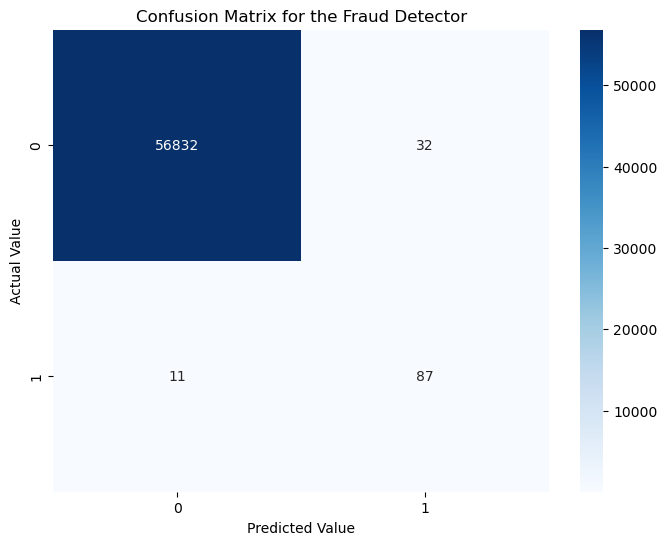

In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("XGBoost and model evaluation libraries imported.")

# Initializing the XGBoost model. I've named it 'fraud_detector'.
fraud_detector = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Training the model on our resampled data. This is the learning step.
print("\nTraining the fraud detector model...")
fraud_detector.fit(X_train_resampled, y_train_resampled)
print("Training complete!")

# Making predictions on the unseen test data.
predictions = fraud_detector.predict(X_test)

# Printing the report to see how well our model performed.
print("\n--- Model Evaluation Report ---")
print(classification_report(y_test, predictions))

# Visualizing the results with a confusion matrix.
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for the Fraud Detector')
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.show()

SHAP and NumPy libraries imported.

Calculating SHAP values...
SHAP values are ready!

Plot 1: Top features the model uses.


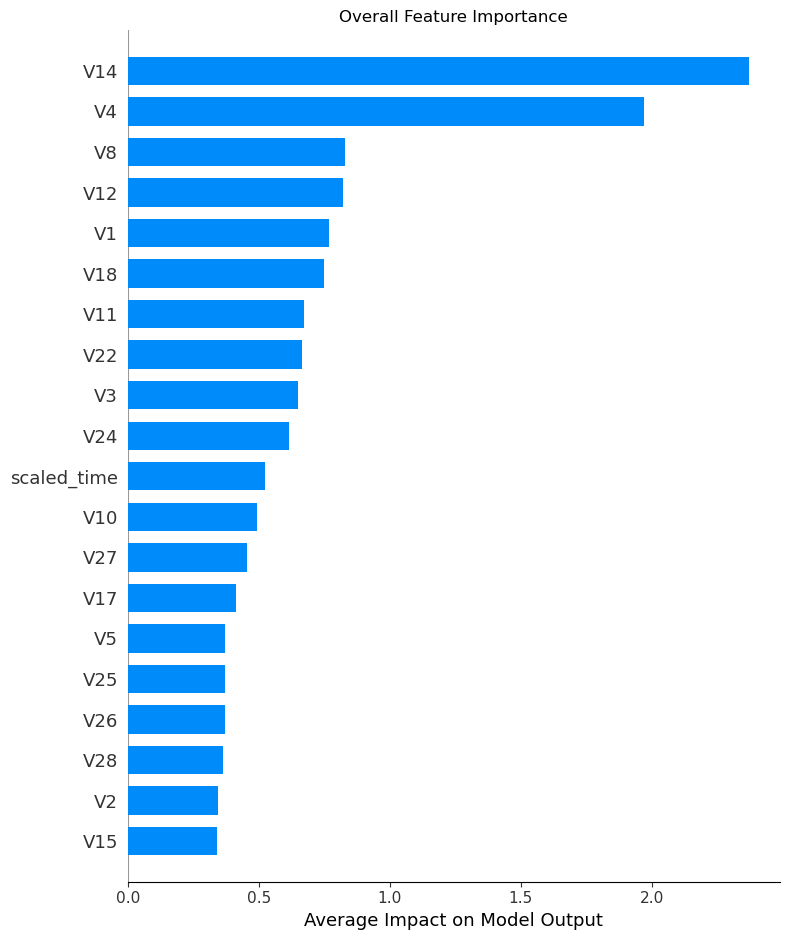


Plot 2: How feature values affect the prediction.


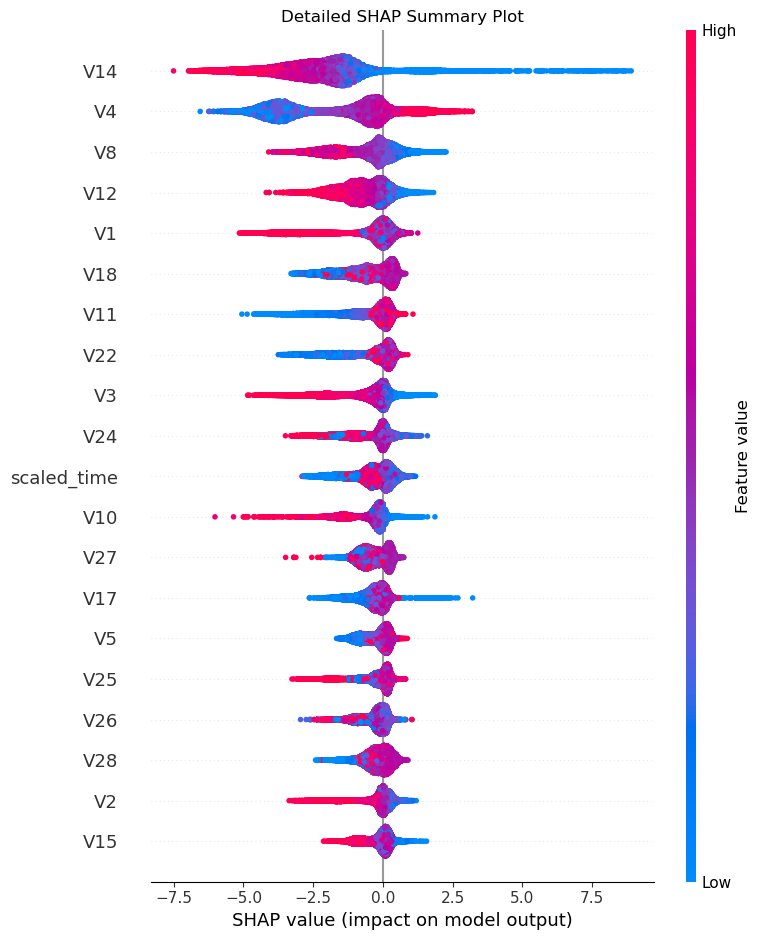


Plot 3: Why a specific transaction was flagged as fraud.


Displaying analysis for transaction index: 840


In [8]:
import shap
import numpy as np
import matplotlib.pyplot as plt

print("SHAP and NumPy libraries imported.")

# --- Explaining the model with SHAP ---
print("\nCalculating SHAP values...")
explainer = shap.TreeExplainer(fraud_detector)
shap_values = explainer.shap_values(X_test)
print("SHAP values are ready!")

# --- Plot 1: Overall Feature Importance ---
print("\nPlot 1: Top features the model uses.")
# Setting a good size for the plot so feature names are readable.
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Overall Feature Importance")
plt.xlabel("Average Impact on Model Output") # Adding a clear label for the x-axis
plt.tight_layout() # Adjusting layout to prevent text overlap
plt.show()

# --- Plot 2: Detailed Feature Impact ---
print("\nPlot 2: How feature values affect the prediction.")
# This plot needs a title for clarity. The default size is usually okay.
plt.title("Detailed SHAP Summary Plot")
shap.summary_plot(shap_values, X_test, show=False) # show=False to control when the plot is displayed
plt.tight_layout()
plt.show()

# --- Plot 3: Analyzing a Single Fraud Case ---
print("\nPlot 3: Why a specific transaction was flagged as fraud.")
shap.initjs() # Initializing javascript for the interactive force plot

# A simple check to prevent errors if no fraud is in the test set.
fraud_indices = np.where(y_test == 1)[0]
if len(fraud_indices) > 0:
    first_fraud_index = fraud_indices[0]
    # The force plot doesn't use plt.figure, its size is controlled differently,
    # but having a clear print statement acts as its title.
    print(f"Displaying analysis for transaction index: {first_fraud_index}")
    display(shap.force_plot(explainer.expected_value, shap_values[first_fraud_index,:], X_test.iloc[first_fraud_index,:]))
else:
    print("No fraud cases found in the test set to analyze.")